In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings

In [2]:
df=pd.read_csv('Date and model wise sale.csv')

In [3]:
df.head()

,Date,Model,Count
0,31-Aug-16,M45,5
1,31-Aug-16,M121,3
2,31-Aug-16,M122,4
3,31-Aug-16,M91,10
4,31-Aug-16,M66,57


In [4]:
df.iloc[::-1].head()

,Date,Model,Count
46115,01-Jan-14,M58,1
46114,01-Jan-14,M54,1
46113,01-Jan-14,M60,5
46112,01-Jan-14,M59,1
46111,01-Jan-14,M74,1


In [5]:
df['Date']=pd.to_datetime(df['Date'])

In [6]:
df=df.groupby('Date')['Count'].count().reset_index()

In [7]:
df.isnull().sum()

Date     0
Count    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    971 non-null    datetime64[ns]
 1   Count   971 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 KB


In [9]:
df.head()

,Date,Count
0,2014-01-01,7
1,2014-01-02,4
2,2014-01-03,1
3,2014-01-04,2
4,2014-01-07,2


In [10]:
df=df.groupby([df['Date'].dt.year,df['Date'].dt.month]).sum().reset_index(drop=True)

In [11]:
timestamp=pd.date_range(start='2014-01-01',end='2016-08-31',freq ='M')
df['Time_Stamp']=timestamp

In [12]:
df.set_index('Time_Stamp',drop=True,inplace=True)

<AxesSubplot:xlabel='Time_Stamp'>

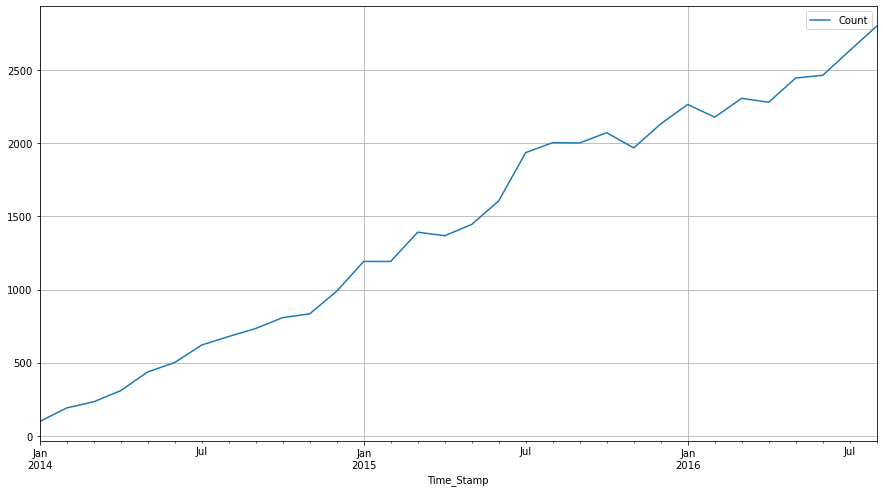

In [13]:
rcParams['figure.figsize']=15,8
df.plot(grid=True)

In [14]:
df_quarterly_sum = df.resample('Q').sum()
df_quarterly_sum.head()

,Count
Time_Stamp,
2014-03-31,522
2014-06-30,1247
2014-09-30,2034
2014-12-31,2631
2015-03-31,3776


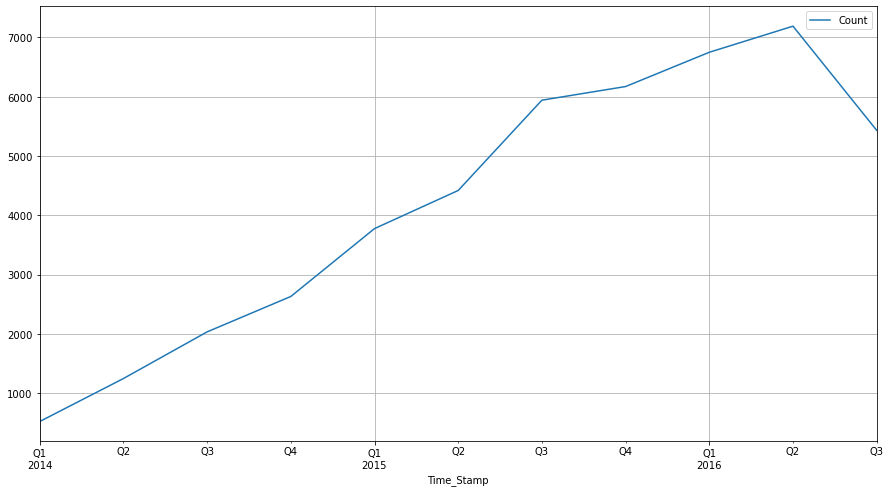

In [15]:
df_quarterly_sum.plot();
plt.grid()

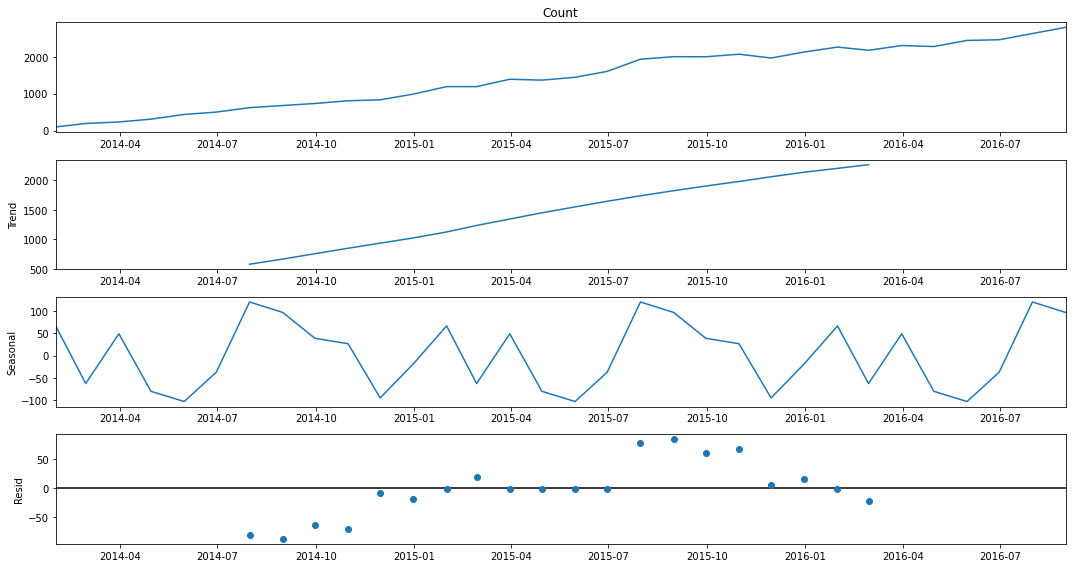

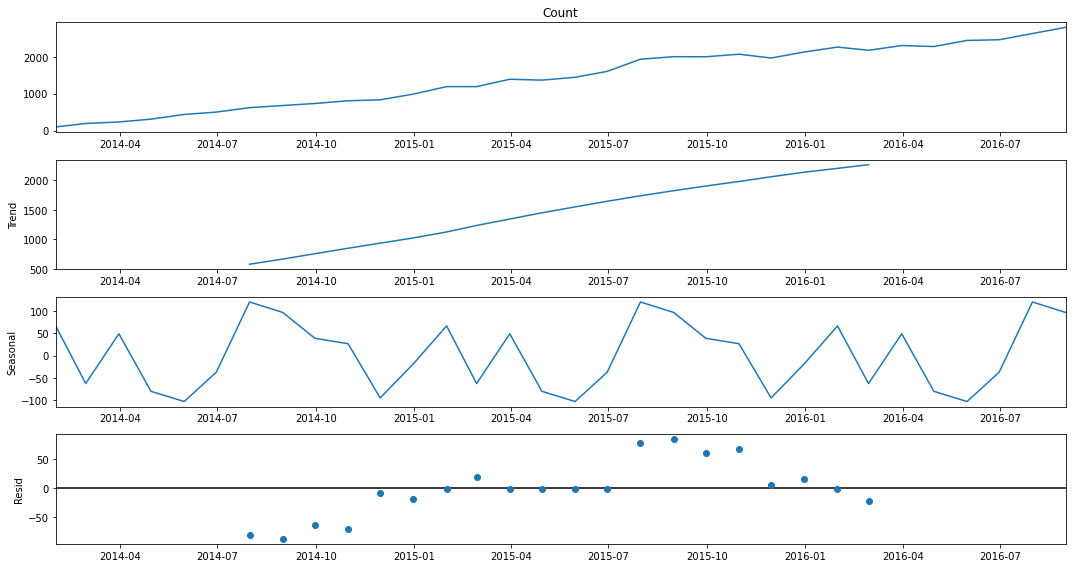

In [16]:
decomposition=seasonal_decompose(df['Count'],model='additive')
decomposition.plot()

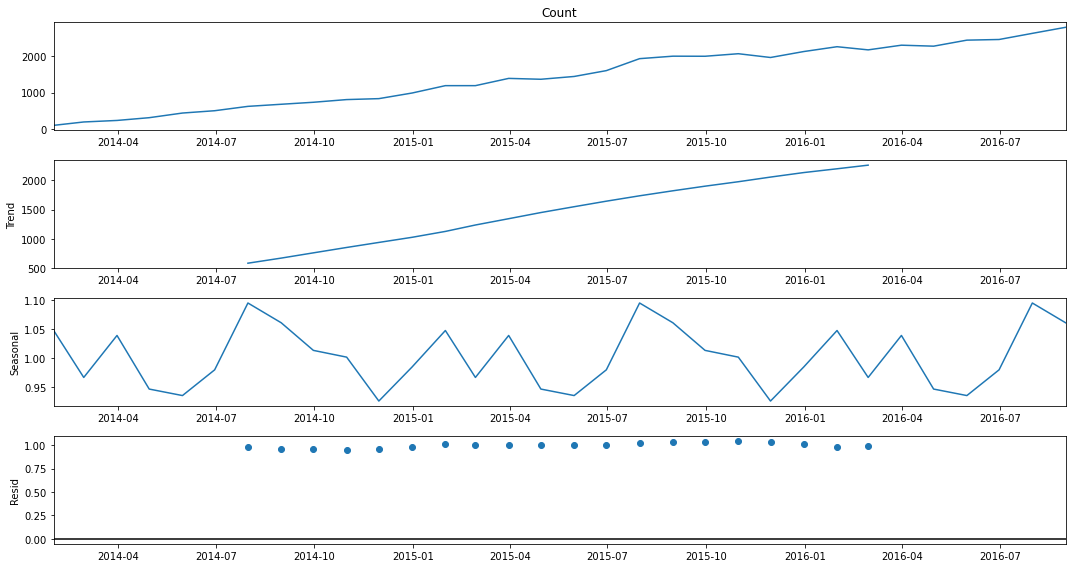

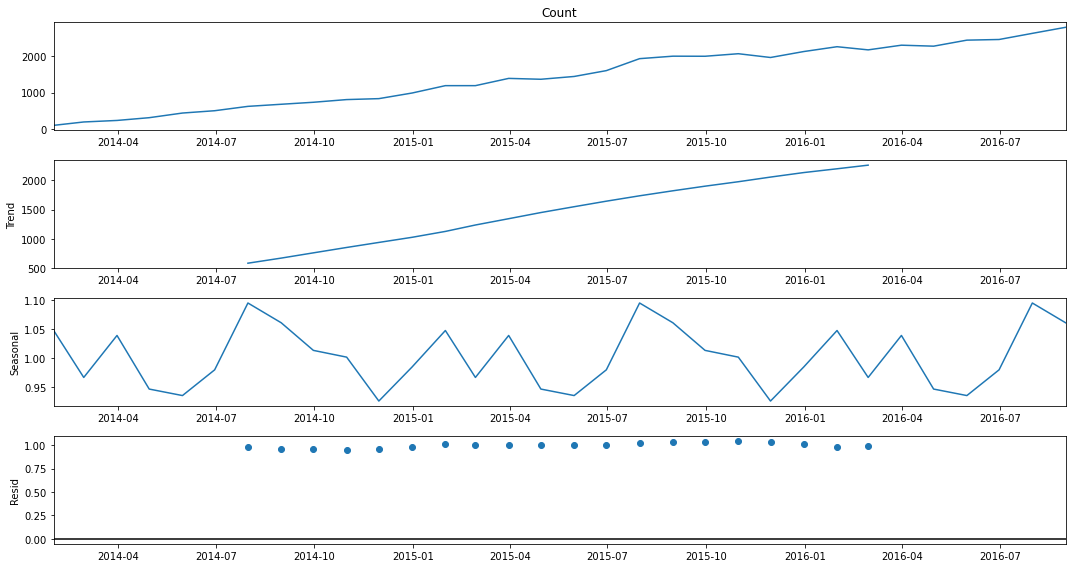

In [17]:
decomposition=seasonal_decompose(df['Count'],model='multiplicative')
decomposition.plot()

In [18]:
df=df.reset_index()

In [19]:
train =df[df['Time_Stamp'].dt.year<2016]
test =df[df['Time_Stamp'].dt.year>=2016]

In [20]:
train=train.set_index('Time_Stamp',drop=True)

In [21]:
test=test.reset_index()

In [22]:
test=test.drop('index',axis=1)

In [23]:
test=test.set_index('Time_Stamp',drop=True)

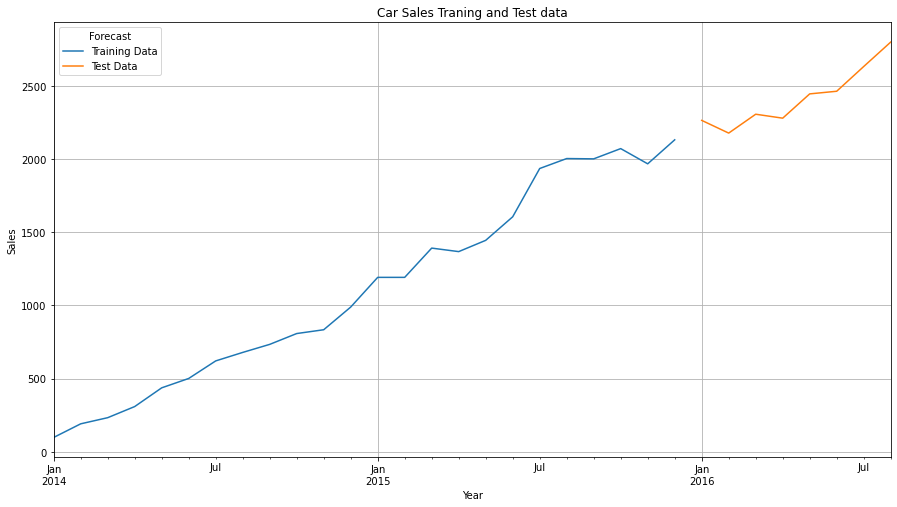

In [24]:
train['Count'].plot()
test['Count'].plot()
plt.grid()
plt.title('Car Sales Traning and Test data')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(['Training Data','Test Data'],title='Forecast')

In [25]:
print(len(train))
print(len(test))

24
8


In [26]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+25 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Test Time instance 
 [25, 26, 27, 28, 29, 30, 31, 32]


In [27]:
train['instance']=train_time

In [28]:
test['instance']=test_time

In [29]:
test

,Count,instance
Time_Stamp,,
2016-01-31,2265,25
2016-02-29,2178,26
2016-03-31,2307,27
2016-04-30,2280,28
2016-05-31,2446,29
2016-06-30,2464,30
2016-07-31,2633,31
2016-08-31,2800,32


In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
lr = LinearRegression()

In [32]:
lr.fit(np.array(train['instance']).reshape(-1,1),train['Count'].values)

LinearRegression()

In [33]:
predictions=lr.predict(np.array(test['instance']).reshape(-1,1))

In [34]:
train.head()

,Count,instance
Time_Stamp,,
2014-01-31,98,1
2014-02-28,191,2
2014-03-31,233,3
2014-04-30,309,4
2014-05-31,437,5


In [35]:
test['predictions_reg']=predictions

In [36]:
test

,Count,instance,predictions_reg
Time_Stamp,,,
2016-01-31,2265,25,2290.079710
2016-02-29,2178,26,2384.142754
2016-03-31,2307,27,2478.205797
2016-04-30,2280,28,2572.268841
2016-05-31,2446,29,2666.331884
2016-06-30,2464,30,2760.394928
2016-07-31,2633,31,2854.457971
2016-08-31,2800,32,2948.521014


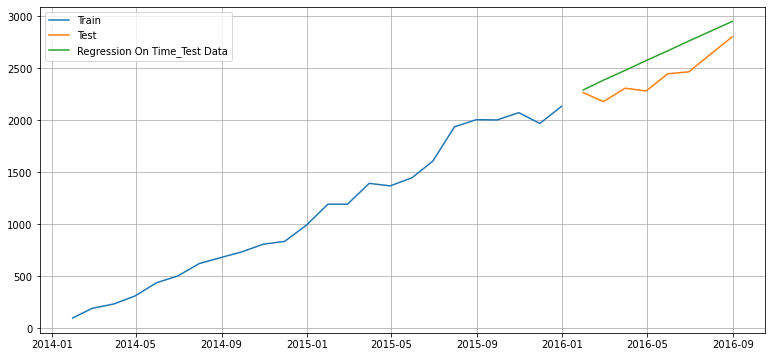

In [37]:
plt.figure(figsize=(13,6))
plt.plot(train['Count'],label='Train')
plt.plot(test['Count'],label='Test')
plt.plot(test['predictions_reg'],label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid()

In [38]:
from sklearn import metrics

In [39]:
rmse_model1_test=metrics.mean_squared_error(test['Count'],test['predictions_reg'],squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 213.704


In [40]:
resultsDf=pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
resultsDf

,Test RMSE
RegressionOnTime,213.703809


In [41]:
MovingAverage=df.copy()
MovingAverage.head()

,Time_Stamp,Count
0,2014-01-31,98
1,2014-02-28,191
2,2014-03-31,233
3,2014-04-30,309
4,2014-05-31,437


In [42]:
MovingAverage['Trailing_2']=MovingAverage['Count'].rolling(2).mean()
MovingAverage['Trailing_4']=MovingAverage['Count'].rolling(4).mean()
MovingAverage['Trailing_6']=MovingAverage['Count'].rolling(6).mean()
MovingAverage['Trailing_9']=MovingAverage['Count'].rolling(9).mean()

MovingAverage.tail()

,Time_Stamp,Count,Trailing_2,Trailing_4,Trailing_6,Trailing_9
27,2016-04-30,2280,2293.5,2257.50,2188.333333,2134.222222
28,2016-05-31,2446,2363.0,2302.75,2268.000000,2183.333333
29,2016-06-30,2464,2455.0,2374.25,2323.333333,2234.666667
30,2016-07-31,2633,2548.5,2455.75,2384.666667,2297.000000
31,2016-08-31,2800,2716.5,2585.75,2488.333333,2389.444444


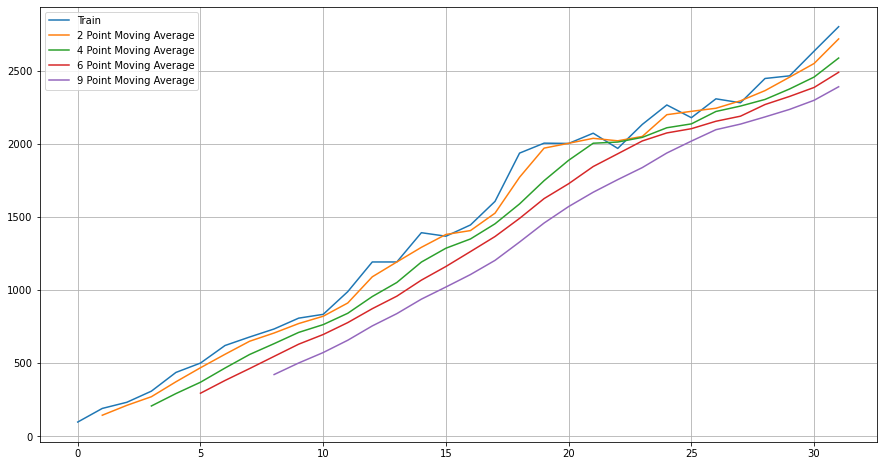

In [43]:
plt.plot(MovingAverage['Count'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid()

In [44]:
trailing_MovingAverage_train=MovingAverage[0:int(len(MovingAverage)*0.75)] 
trailing_MovingAverage_test=MovingAverage[int(len(MovingAverage)*0.75):]

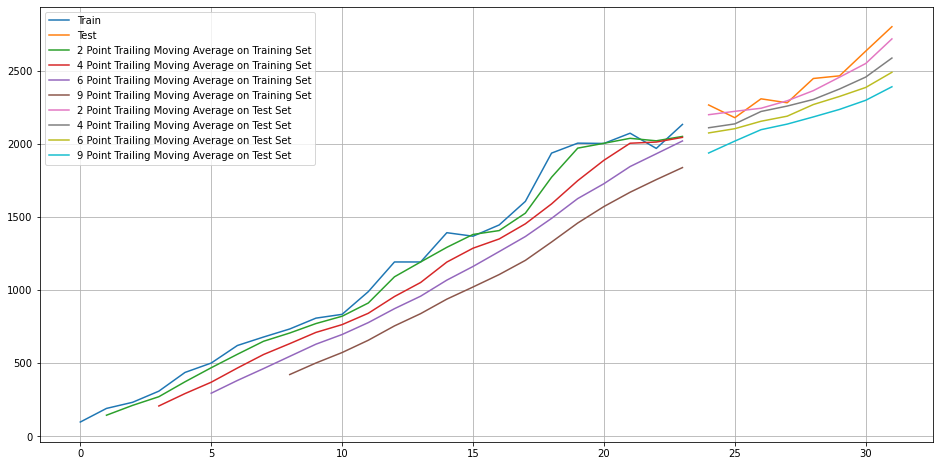

In [45]:
plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['Count'], label='Train')
plt.plot(trailing_MovingAverage_test['Count'], label='Test')

plt.plot(trailing_MovingAverage_train['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_4'], label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_6'],label = '6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train['Trailing_9'],label = '9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid()

In [46]:
rmse_model4_test_2 = metrics.mean_squared_error(trailing_MovingAverage_test['Count'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2))

rmse_model4_test_4 = metrics.mean_squared_error(trailing_MovingAverage_test['Count'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_4))

rmse_model4_test_6 = metrics.mean_squared_error(trailing_MovingAverage_test['Count'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

rmse_model4_test_9 = metrics.mean_squared_error(trailing_MovingAverage_test['Count'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f " %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 62.988
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 132.253
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 188.542
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 274.358 


In [47]:
resultsDf_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsDf = pd.concat([resultsDf,resultsDf_4])
resultsDf

,Test RMSE
RegressionOnTime,213.703809
2pointTrailingMovingAverage,62.987598
4pointTrailingMovingAverage,132.253485
6pointTrailingMovingAverage,188.542196
9pointTrailingMovingAverage,274.358072


In [48]:
TES_train = train.copy()
TES_test = test.copy()

In [49]:
model_TES = ExponentialSmoothing(TES_train['Count'],trend='add',seasonal='multiplicative',freq='M')

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [50]:
model_TES_autofit = model_TES.fit()

In [51]:
model_TES_autofit.params

{'smoothing_level': 0.8535695561775596,
 'smoothing_trend': 0.00010026663293705271,
 'smoothing_seasonal': 0.14643030862173423,
 'damping_trend': nan,
 'initial_level': 644.998395909563,
 'initial_trend': 96.32054178984436,
 'initial_seasons': array([1.28949749, 1.4768695 , 1.7376943 , 1.55125768, 1.49907295,
        1.58938778, 1.77271018, 1.73451104, 1.67667486, 1.62509916,
        1.47605127, 1.54575451]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [52]:
TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
TES_test

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


,Count,instance,predictions_reg,auto_predict
Time_Stamp,,,,
2016-01-31,2265,25,2290.079710,1778.795280
2016-02-29,2178,26,2384.142754,2099.032410
2016-03-31,2307,27,2478.205797,2673.949457
2016-04-30,2280,28,2572.268841,2657.046349
2016-05-31,2446,29,2666.331884,2780.920233
2016-06-30,2464,30,2760.394928,3035.263600
2016-07-31,2633,31,2854.457971,3567.482168
2016-08-31,2800,32,2948.521014,3659.917983


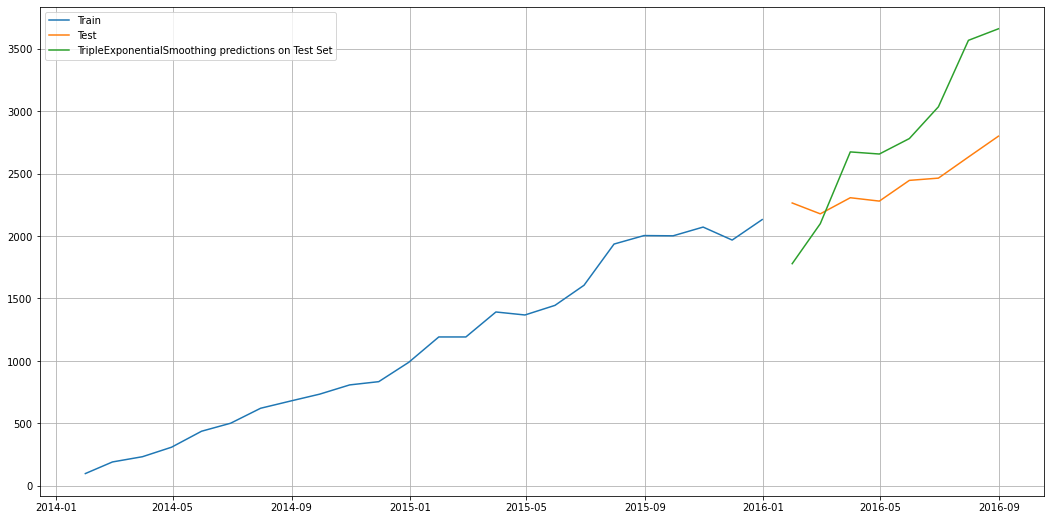

In [53]:
plt.figure(figsize=(18,9))
plt.plot(TES_train['Count'], label='Train')
plt.plot(TES_test['Count'], label='Test')

plt.plot(TES_test['auto_predict'], label='TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()

In [54]:
rmse_model6_test_1 = metrics.mean_squared_error(TES_test['Count'],TES_test['auto_predict'],squared=False)
print("Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is %3.3f" %(rmse_model6_test_1))

Triple Exponential Smoothing Model forecast on the Test Data,  RMSE is 566.864


In [55]:
resultsDf_8_1 = pd.DataFrame({'Test RMSE': [rmse_model6_test_1]}
                           ,index=['Alpha=0.85,Beta=0,Gamma=0.14,TripleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_8_1])
resultsDf

,Test RMSE
RegressionOnTime,213.703809
2pointTrailingMovingAverage,62.987598
4pointTrailingMovingAverage,132.253485
6pointTrailingMovingAverage,188.542196
9pointTrailingMovingAverage,274.358072
"Alpha=0.85,Beta=0,Gamma=0.14,TripleExponentialSmoothing",566.863772


In [56]:
DES_train=train.copy()
DES_test=test.copy()

In [57]:
model_DES=Holt(DES_train['Count'])

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [58]:
resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Test RMSE': []})
resultsDf_7

,Alpha Values,Beta Values,Train RMSE,Test RMSE


In [59]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=12)
        
        rmse_model6_train = metrics.mean_squared_error(DES_train['Count'],DES_train['predict',i,j],squared=False)
        
        rmse_model6_test = metrics.mean_squared_error(DES_test['Count'],DES_test['predict',i,j],squared=False)
        
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse_model6_train
                                          ,'Test RMSE':rmse_model6_test},ignore_index=True )

C:\Users\91750\AppData\Local\Temp/ipykernel_19644/1849837828.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\91750\AppData\Local\Temp/ipykernel_19644/1849837828.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\91750\AppData\Local\Temp/ipykernel_19644/1849837828.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\91750\AppData\Local\Temp/ipykernel_19644/1849837828.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
C:

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\91750\AppData\Local\Temp/ipykernel_19644/1849837828.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
C:\Users\91750\AppData\Local\Temp/ipykernel_19644/1849837828.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
C:

In [60]:
resultsDf_7

,Alpha Values,Beta Values,Train RMSE,Test RMSE
0,0.3,0.3,105.113218,185.799902
1,0.3,0.4,106.405771,135.029402
2,0.3,0.5,107.586515,102.082593
3,0.3,0.6,108.976791,121.384302
4,0.3,0.7,110.560436,178.421414
...,...,...,...,...
59,1.0,0.6,110.785463,114.377678
60,1.0,0.7,115.081607,175.471331
61,1.0,0.8,119.837011,262.586580
62,1.0,0.9,125.224183,369.526237


In [61]:
resultsDf_7.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Train RMSE,Test RMSE
57,1.0,0.4,103.005250,80.374958
48,0.9,0.3,97.539837,80.605933
51,0.9,0.6,106.595119,80.653589
46,0.8,0.9,111.679031,81.719804
56,1.0,0.3,99.344515,81.796790


In [62]:
resultsDf_7_1 = pd.DataFrame({'Test RMSE': [resultsDf_7.sort_values(by=['Test RMSE']).values[0][3]]}
                           ,index=['Alpha=1,Beta=0.4,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, resultsDf_7_1])
resultsDf

,Test RMSE
RegressionOnTime,213.703809
2pointTrailingMovingAverage,62.987598
4pointTrailingMovingAverage,132.253485
6pointTrailingMovingAverage,188.542196
9pointTrailingMovingAverage,274.358072
"Alpha=0.85,Beta=0,Gamma=0.14,TripleExponentialSmoothing",566.863772
"Alpha=1,Beta=0.4,DoubleExponentialSmoothing",80.374958


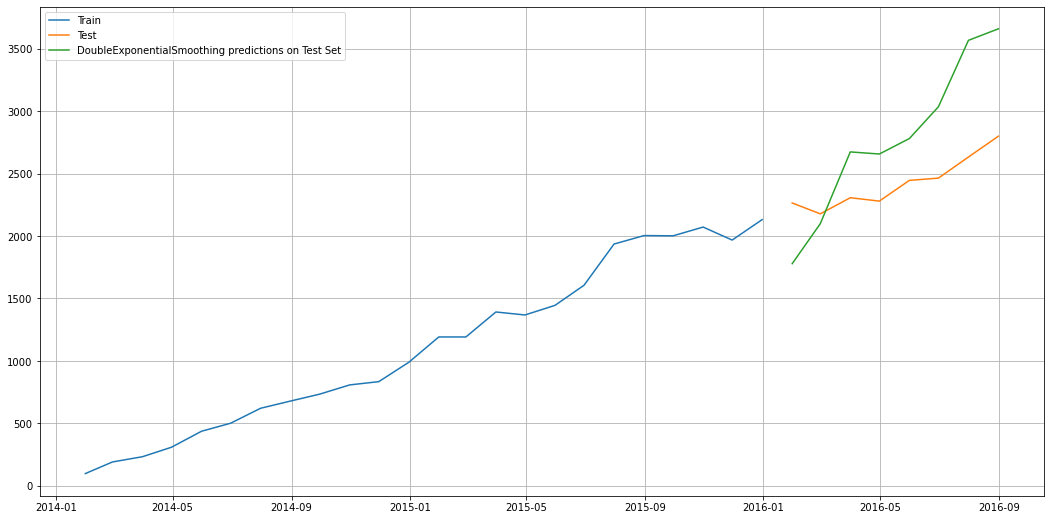

In [63]:
plt.figure(figsize=(18,9))
plt.plot(TES_train['Count'], label='Train')
plt.plot(TES_test['Count'], label='Test')

plt.plot(TES_test['auto_predict'], label='DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()

In [64]:
df=df.set_index('Time_Stamp')

In [65]:
dftest = adfuller(df,regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -3.325
DF test p-value is 0.06224877068948425
Number of lags used 10


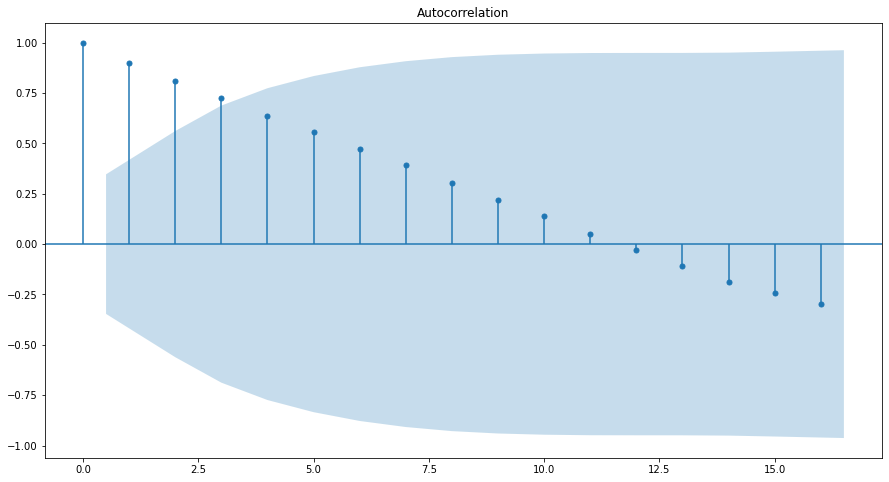

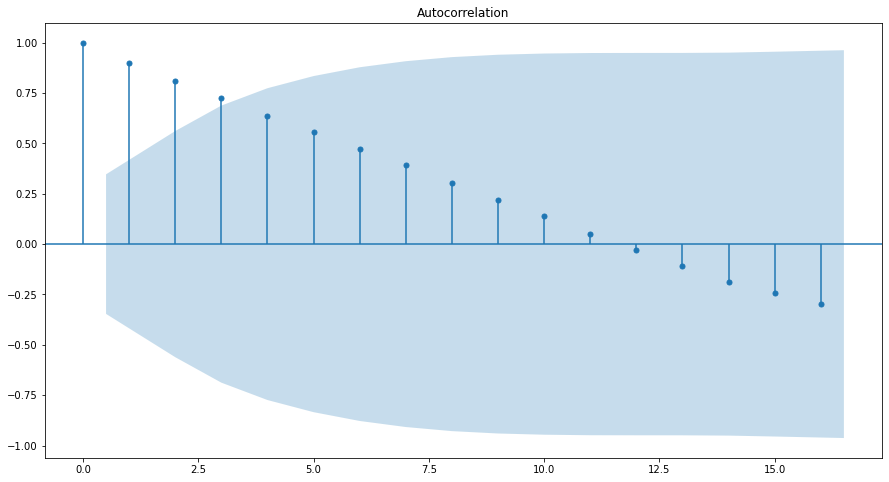

In [66]:
plot_acf(df,alpha=0.05)

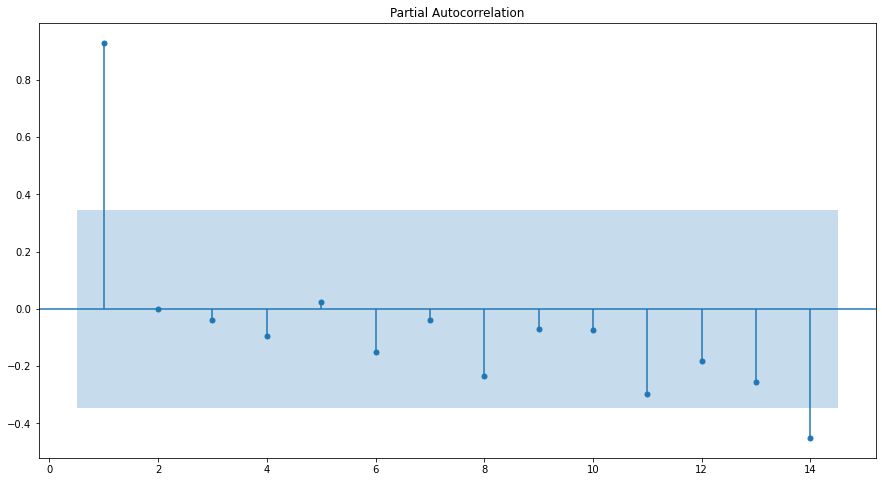

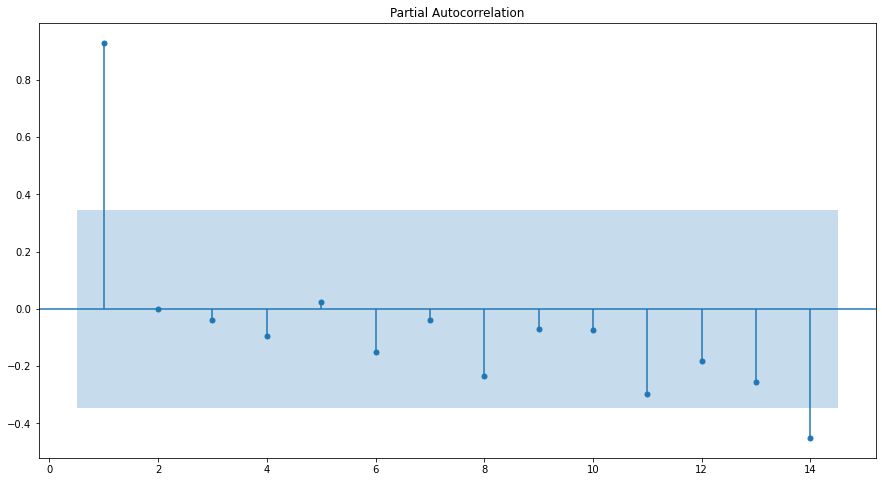

In [67]:
plot_pacf(df,zero=False,lags=14,alpha=0.05)

In [68]:
TS_Train =df[df.index.year<2016]
TS_Test =df[df.index.year>=2016]

In [69]:
dftest = adfuller(TS_Train,regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -2.305
DF test p-value is 0.43109028663215465
Number of lags used 8


In [70]:
dftest = adfuller(np.log(TS_Train).diff(2).dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -10.064
DF test p-value is 1.6922760490873973e-15
Number of lags used 8


In [71]:
df_diff=np.log(TS_Train).diff(2)

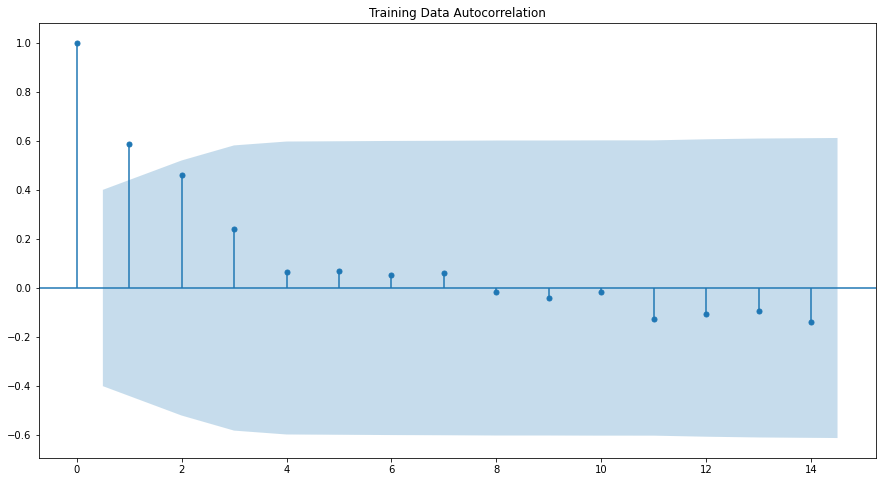

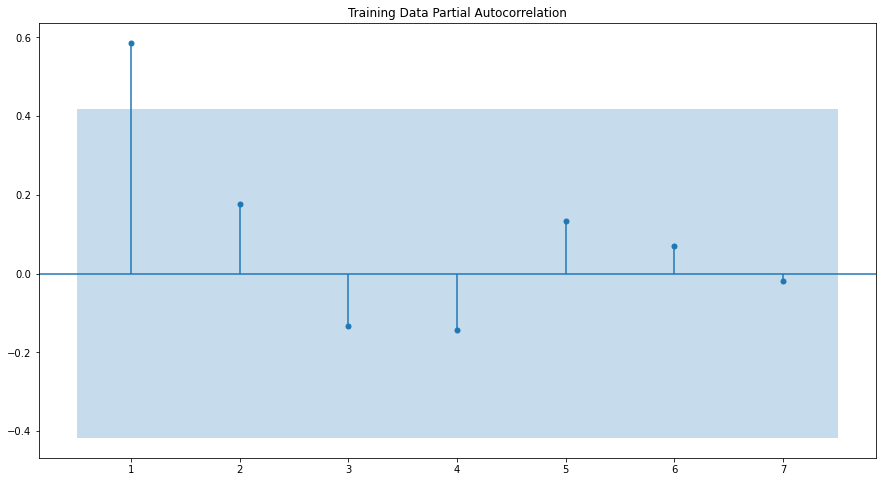

In [72]:
plot_acf(df_diff,title='Training Data Autocorrelation',missing='drop')
plot_pacf(df_diff.dropna(),title='Training Data Partial Autocorrelation',lags=7,zero=False,method='ywmle')
plt.show()

In [73]:
import itertools
p = q = range(0,4)
d= range(0,3)
pdq = list(itertools.product(p, d, q))
print('Examples of the parameter combinations for the Model')
for i in range(0,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Examples of the parameter combinations for the Model
Model: (0, 0, 0)
Model: (0, 0, 1)
Model: (0, 0, 2)
Model: (0, 0, 3)
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (0, 2, 0)
Model: (0, 2, 1)
Model: (0, 2, 2)
Model: (0, 2, 3)
Model: (1, 0, 0)
Model: (1, 0, 1)
Model: (1, 0, 2)
Model: (1, 0, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (1, 2, 0)
Model: (1, 2, 1)
Model: (1, 2, 2)
Model: (1, 2, 3)
Model: (2, 0, 0)
Model: (2, 0, 1)
Model: (2, 0, 2)
Model: (2, 0, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (2, 2, 0)
Model: (2, 2, 1)
Model: (2, 2, 2)
Model: (2, 2, 3)
Model: (3, 0, 0)
Model: (3, 0, 1)
Model: (3, 0, 2)
Model: (3, 0, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)
Model: (3, 2, 0)
Model: (3, 2, 1)
Model: (3, 2, 2)
Model: (3, 2, 3)


In [74]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [75]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(df_diff.values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 0, 0) - AIC:-1.9960163002222941
ARIMA(0, 0, 1) - AIC:-11.284761760751024
ARIMA(0, 0, 2) - AIC:-10.90665388391901
ARIMA(0, 0, 3) - AIC:-17.370375436377895


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0) - AIC:-7.038269400119599
ARIMA(0, 1, 1) - AIC:-5.580788259579618
ARIMA(0, 1, 2) - AIC:-3.815086019239624
ARIMA(0, 1, 3) - AIC:-1.8408731282977975
ARIMA(0, 2, 0) - AIC:23.414492564251624
ARIMA(0, 2, 1) - AIC:13.964684583035647
ARIMA(0, 2, 2) - AIC:14.73392412211406
ARIMA(0, 2, 3) - AIC:15.30791951228587
ARIMA(1, 0, 0) - AIC:-18.804454808298363
ARIMA(1, 0, 1) - AIC:-17.13601974719508
ARIMA(1, 0, 2) - AIC:-16.796886918719967


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 3) - AIC:-15.542719700624716
ARIMA(1, 1, 0) - AIC:-5.672213083243783
ARIMA(1, 1, 1) - AIC:-3.681959943969243
ARIMA(1, 1, 2) - AIC:-1.8198193090183068


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 3) - AIC:-0.7101383589207444
ARIMA(1, 2, 0) - AIC:19.632713192450023
ARIMA(1, 2, 1) - AIC:14.920981680032014
ARIMA(1, 2, 2) - AIC:15.46741584418314
ARIMA(1, 2, 3) - AIC:16.40561351681048
ARIMA(2, 0, 0) - AIC:-17.228673496760287
ARIMA(2, 0, 1) - AIC:-15.25813975191209


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) - AIC:-14.920269819094312
ARIMA(2, 0, 3) - AIC:-12.000323358045659
ARIMA(2, 1, 0) - AIC:-3.698120399915677


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) - AIC:-2.3513408643205054
ARIMA(2, 1, 2) - AIC:-0.37875769113120583
ARIMA(2, 1, 3) - AIC:-0.9725222863478926
ARIMA(2, 2, 0) - AIC:17.676964328362118
ARIMA(2, 2, 1) - AIC:16.768308085779307
ARIMA(2, 2, 2) - AIC:17.272026859661338


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 3) - AIC:18.20190890117349
ARIMA(3, 0, 0) - AIC:-15.33663067898883
ARIMA(3, 0, 1) - AIC:-14.106869025963384


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 2) - AIC:-14.581013692563623
ARIMA(3, 0, 3) - AIC:-11.510610171480053
ARIMA(3, 1, 0) - AIC:-2.0657281359457116
ARIMA(3, 1, 1) - AIC:-1.5460599007846731
ARIMA(3, 1, 2) - AIC:0.30716990687315615


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) - AIC:0.9566624682764946
ARIMA(3, 2, 0) - AIC:19.613745084051352
ARIMA(3, 2, 1) - AIC:18.736743977358145
ARIMA(3, 2, 2) - AIC:19.41982507121928
ARIMA(3, 2, 3) - AIC:21.25525340387412


C:\Users\91750\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
12,"(1, 0, 0)",-18.804455
3,"(0, 0, 3)",-17.370375
24,"(2, 0, 0)",-17.228673
13,"(1, 0, 1)",-17.136020
14,"(1, 0, 2)",-16.796887


In [77]:
auto_ARIMA = ARIMA(TS_Train, order=(2,0,3))

results_auto_ARIMA = auto_ARIMA.fit()

print(results_auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   24
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -147.967
Date:                Fri, 07 Apr 2023   AIC                            309.935
Time:                        20:03:08   BIC                            318.181
Sample:                    01-31-2014   HQIC                           312.122
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1114.3032    888.297      1.254      0.210    -626.727    2855.334
ar.L1          0.5189      0.542      0.958      0.338      -0.542       1.580
ar.L2          0.4463      0.547      0.815      0.4

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: Use

In [78]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(TS_Test))

In [79]:
rmse = mean_squared_error(TS_Test['Count'],predicted_auto_ARIMA,squared=False)
mape = mean_absolute_percentage_error(TS_Test['Count'],predicted_auto_ARIMA)
print('RMSE:',rmse,'\nMAPE:',mape)

RMSE: 335.4531268853061 
MAPE: 0.09717872013305548


In [80]:
temp_resultsDf = pd.DataFrame({'Test RMSE':rmse}
                           ,index=['ARIMA'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,Test RMSE
RegressionOnTime,213.703809
2pointTrailingMovingAverage,62.987598
4pointTrailingMovingAverage,132.253485
6pointTrailingMovingAverage,188.542196
9pointTrailingMovingAverage,274.358072
"Alpha=0.85,Beta=0,Gamma=0.14,TripleExponentialSmoothing",566.863772
"Alpha=1,Beta=0.4,DoubleExponentialSmoothing",80.374958
ARIMA,335.453127


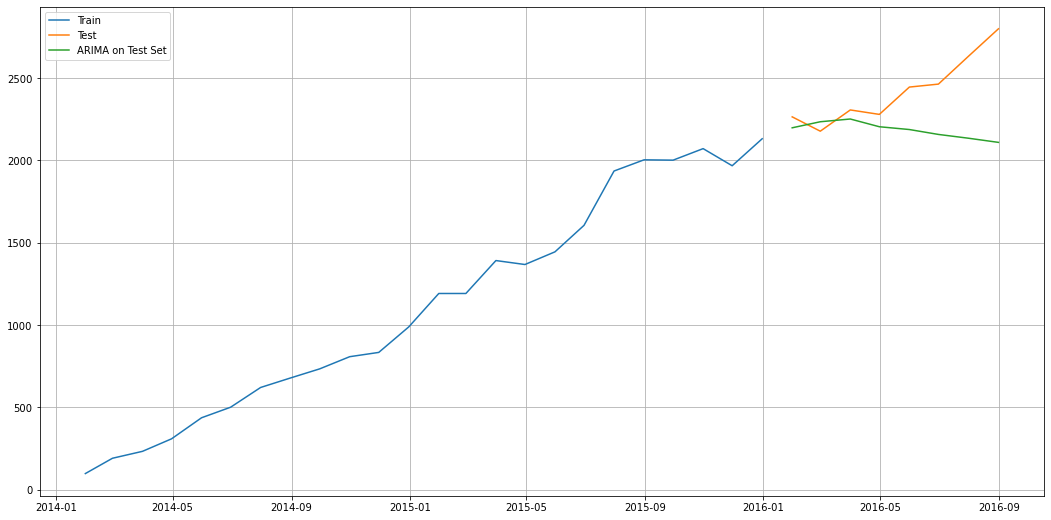

In [81]:
plt.figure(figsize=(18,9))
plt.plot(TES_train['Count'], label='Train')
plt.plot(TES_test['Count'], label='Test')

plt.plot(predicted_auto_ARIMA,label='ARIMA on Test Set')


plt.legend(loc='best')
plt.grid()

In [82]:
model_DES=Holt(df['Count'])

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [83]:
fullmodel = model_DES.fit(smoothing_level=1,smoothing_slope=0.4,optimized=False,use_brute=True)

C:\Users\91750\AppData\Local\Temp/ipykernel_19644/2521589708.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fullmodel = model_DES.fit(smoothing_level=1,smoothing_slope=0.4,optimized=False,use_brute=True)


In [84]:
prediction=fullmodel.forecast(steps=4)

C:\Users\91750\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time_Stamp'>

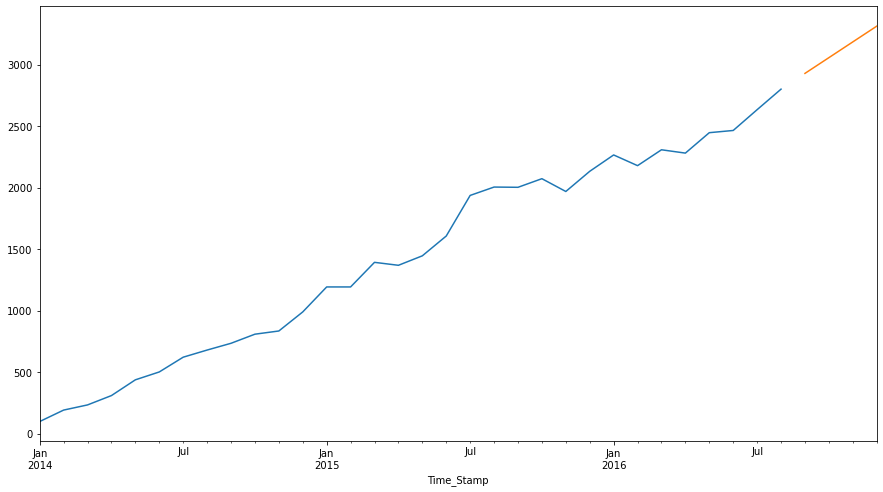

In [85]:
df['Count'].plot()
prediction.plot()

In [86]:
prediction

2016-09-30    2927.937546
2016-10-31    3055.875092
2016-11-30    3183.812637
2016-12-31    3311.750183
Freq: M, dtype: float64

In [87]:
import pickle

In [88]:
pickle.dump(fullmodel,open('model.pkl','wb'))

In [89]:
model=pickle.load(open('model.pkl','rb'))

In [90]:
pip install flask

Note: you may need to restart the kernel to use updated packages.


In [91]:
from flask import Flask, render_template,request

In [92]:
app = Flask(__name__)
model = pickle.load(open('model.pkl','rb'))

In [93]:
@app.route('/')
def home():
    return render_template('index.html')